In [28]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"There are {torch.cuda.device_count()} GPUs in total.\nThe first GPU is: {torch.cuda.get_device_properties(0)}")
print(f"Using {device} now!")
print(f"torch version: {torch.__version__}")
if UseGPU:
    print(f"CUDA version: {torch.cuda_version}")

There are 1 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)
Using cuda now!
torch version: 1.10.2+cu113
CUDA version: 11.3


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, _ = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, _ = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, _ = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, _ = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


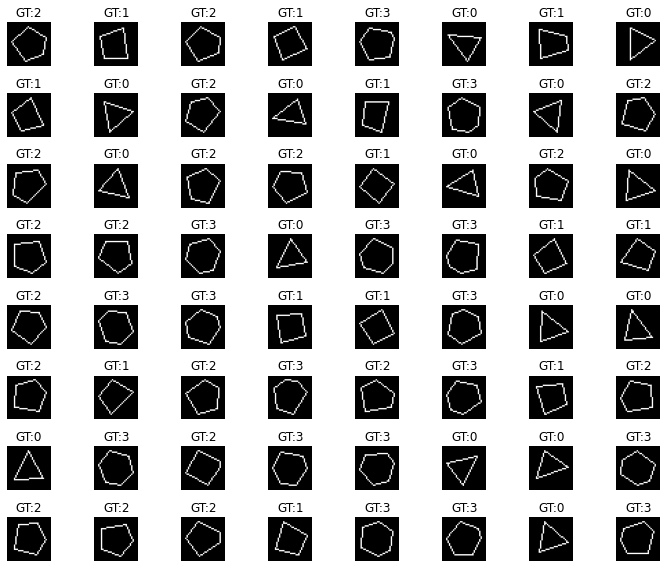

In [7]:
grid_vis(test_loader, 8)

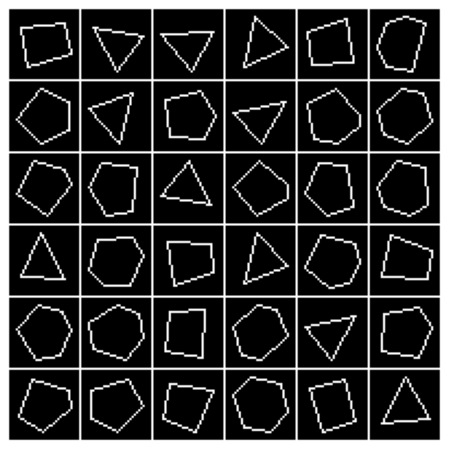

In [8]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [9]:
# Train and test!
check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [10]:
# load modal paras from saved .pt file
model = models.my_ConvNeXt()
model.to(device)

load_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [11]:
model.eval()
check_accuracy(model, test_loader)

Test accuracy is : 96.99%	Infer time: 10.753679037094116


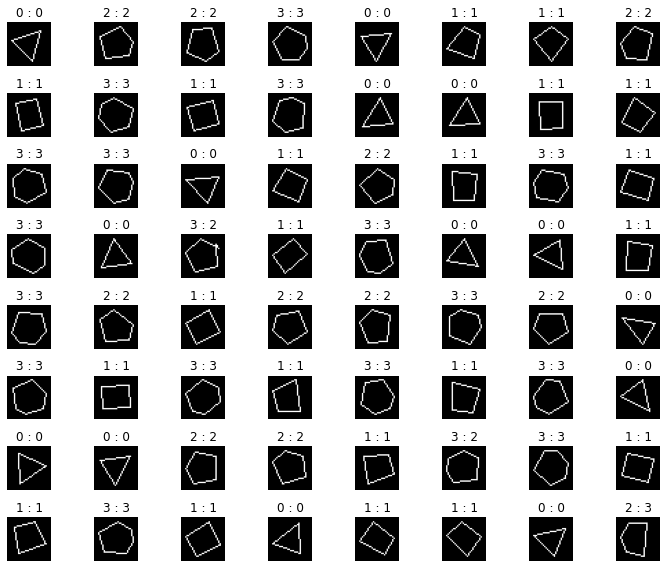

In [12]:
grid_vis(test_loader, 8, model)

In [13]:
vis_model = models.my_ConvNeXt_vis()
vis_model.to(device)

load_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(load_path)
vis_model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [14]:
vis_model

my_ConvNeXt_vis(
  (connection_layers): ModuleList(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (norm_layers): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (pwconv1): Linear(in_features=8, out_features=16, bias=True)
        (act): ReLU()
        (pwconv2): Linear(in_features=16, out_features=8, bias=True)
      )
    )
    (1): Sequential(
      (0): B

In [24]:
img, label = test_data[2000]
img = img[None, :, :, :].to(device, dtype=torch.float32)
# label = label.to(device, dtype=torch.int64)
# vis = img.permute(0, 2, 3, 1)  # (1, C, H, W) -> (1, H, W, C)
scores, mid_outputs = vis_model(img)

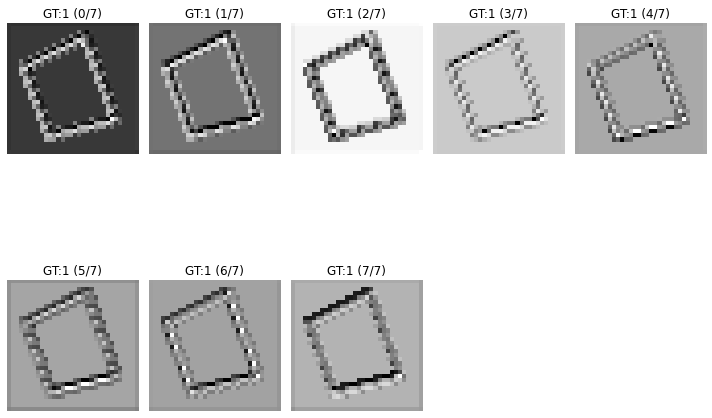

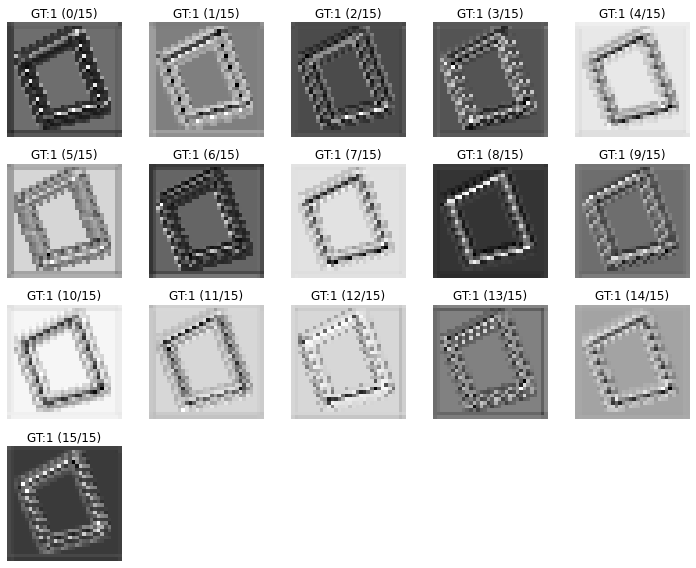

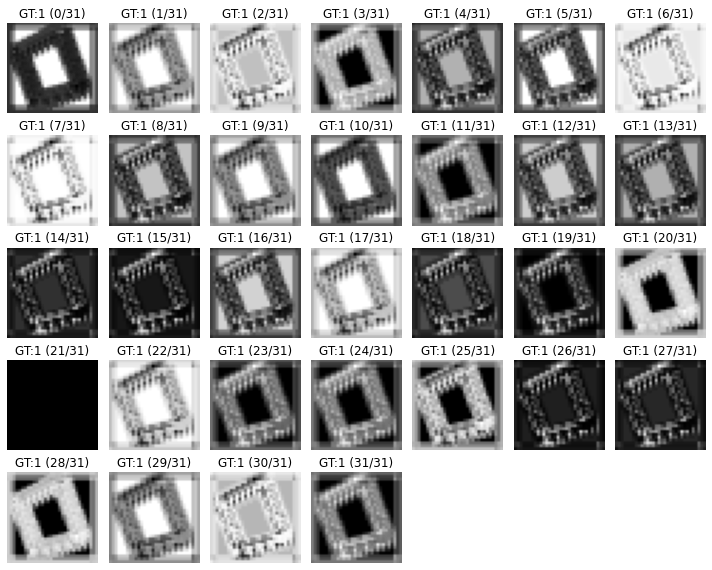

In [27]:
for act in mid_outputs:
    vis_act(act, label)

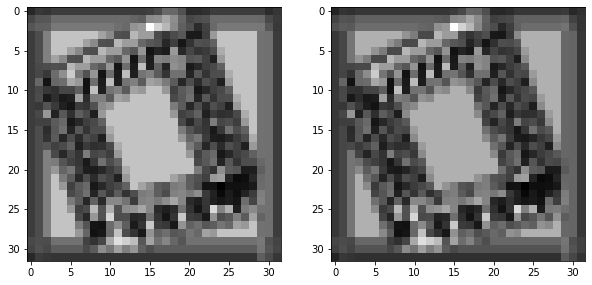

In [65]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(mid_outputs[2][0, 8], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(mid_outputs[2][0, 13], 'gray')
plt.show()

In [83]:
print('min: ', torch.dist(*mid_outputs[2][0, [9, 29]]))
print('max: ', torch.dist(*mid_outputs[2][0, [4, 13]]))
print('abnormal: ', torch.dist(*mid_outputs[2][0, [4, 8]]))
torch.dist(*mid_outputs[2][0, [24, 31]])

min:  tensor(0.0462)
max:  tensor(0.6510)
abnormal:  tensor(1.1006)


tensor(0.1159)

tensor(0.2432)